# Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and read dataset

In [48]:
df = pd.read_csv("food_choices.csv")
selected_columns = ['comfort_food', 'comfort_food_reasons', 'Gender', 'employment']
df = df[selected_columns]

In [49]:
def map_employment(value):
    if value == 2:
        return 1
    elif value == 3:
        return 2
    else:
        return 2

In [50]:
df['employment'] = df['employment'].apply(map_employment)

# Data Preprocessing, handling missing values

In [51]:
df['comfort_food'].fillna('unknown', inplace=True)
df['comfort_food_reasons'].fillna('unknown', inplace=True)
 
missing_values = df.isnull().sum()
print("Missing values after handling:\n", missing_values)

Missing values after handling:
 comfort_food            0
comfort_food_reasons    0
Gender                  0
employment              0
dtype: int64


# Create column food_group base on comfort_food column

In [52]:
def categorize_food(food):
    food = food.lower()
    if any(keyword in food for keyword in ['fruit', 'vegetable', 'grapes', 'carrots', 'broccoli', 'tomato soup', 'spaghetti squash', 'carrots', 'plantain chips', 'almonds', 'watermelon', 'cucumber', 'fritos']):
        return 'Fruit and Vegetables'
    elif any(keyword in food for keyword in ['pizza', 'pasta', 'spaghetti', 'noodles', 'rice', 'potatoes', 'bagels', 'fries', 'taco', 'sandwich', 'hot dog', 'burrito', 'sub', 'macaroni and cheese', 'lasagna', 'mashed potatoes', 'spaghetti squash', 'stuffed peppers', 'meatball sub', 'chicken tikka masala', 'chicken noodle soup', 'chicken pot pie']):
        return 'Starchy food'
    elif any(keyword in food for keyword in ['milk', 'cheese', 'yogurt', 'ice cream', 'mozzarella sticks', 'cottage cheese', 'cheesecake', 'frozen yogurt']):
        return 'Dairy'
    elif any(keyword in food for keyword in ['chicken', 'beef', 'pork', 'fish', 'egg', 'turkey', 'meatball', 'sausage', 'fried chicken', 'grilled chicken', 'chicken fingers', 'beef jerky', 'steak']):
        return 'Protein'
    elif any(keyword in food for keyword in ['chips', 'fries', 'chocolate', 'cake', 'cookie', 'brownie', 'candy', 'soda', 'donut', 'peanut butter', 'burgers', 'garlic bread', 'popcorn', 'pretzels', 'chicken wings', 'doughnut', 'chocolate bar', 'twizzlers', 'chocolate brownie', 'macaroons', 'truffles', 'french fries', 'slim jims', 'chicken curry', 'chocolate chipotle', 'pop', 'mac n cheese', 'rice', 'pizza', 'cheeseburger', 'chicken nuggets', 'peanut butter sandwich', 'mac and cheese', 'cheese and crackers', 'protein bar', 'chex mix', 'cheez-its', 'chicken fingers', 'chips and cheese', 'chips and dip', 'fruit snacks', 'doritos']):
        return 'Fat'
    else:
        return 'Others'

In [53]:
df['food_group'] = df['comfort_food'].apply(categorize_food)

# # Create column mood_category base on comfort_food_reasons column

In [54]:
def map_reasons_to_mood(reasons):
    reason_to_mood = {
        'stress': 'stress/anxiety',
        'anxiety': 'stress/anxiety',
        'boredom': 'boredom',
        'sadness': 'sadness',
        'happiness': 'happiness/celebration',
        'celebration': 'happiness/celebration',
        'other': 'neutral',
        'none': 'neutral',
        'unknown': 'neutral'
    }
    
    reasons_list = [r.strip().lower() for r in reasons.split(',')]
    
    mood_categories = [reason_to_mood.get(reason, 'neutral') for reason in reasons_list]
    
    return mood_categories

In [55]:
df['mood_category'] = df['comfort_food_reasons'].apply(map_reasons_to_mood)

# Prepare data for training

In [56]:
df_exploded = df.explode('mood_category')
X = df_exploded[['Gender', 'mood_category', 'employment']]
y = df_exploded['food_group']

In [57]:
# ohe = OneHotEncoder()
# encoded_features = ohe.fit_transform(df_exploded[['Gender', 'mood_category', 'employment']]).toarray()

In [58]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_encoded = ohe.fit_transform(X)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [32]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Hyperparameter Tuning using GridSearchCV

In [33]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear']
}

classifiers = {
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5),
    "LogisticRegression": GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
}

# Model Training & Evaluation

In [34]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:\n", report)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}\n")

    # Save the trained model
    model_filename = f"{name}_model.pkl"
    joblib.dump(clf, model_filename)
    print(f"Saved {name} model to {model_filename}")

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classifica

Classification Report for GradientBoosting:
                       precision    recall  f1-score   support

               Dairy       0.29      0.56      0.38         9
                 Fat       0.00      0.00      0.00         7
Fruit and Vegetables       0.00      0.00      0.00         5
             Protein       0.00      0.00      0.00         2
        Starchy food       0.48      0.41      0.44        27

            accuracy                           0.32        50
           macro avg       0.15      0.19      0.16        50
        weighted avg       0.31      0.32      0.31        50

Accuracy for GradientBoosting: 0.32

Saved GradientBoosting model to GradientBoosting_model.pkl
Classification Report for LogisticRegression:
                       precision    recall  f1-score   support

               Dairy       0.42      0.56      0.48         9
                 Fat       0.00      0.00      0.00         7
Fruit and Vegetables       0.00      0.00      0.00         5
  

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [35]:
encoder_filename = "one_hot_encoder.pkl"
joblib.dump(ohe, encoder_filename)
print(f"Saved OneHotEncoder to {encoder_filename}")

Saved OneHotEncoder to one_hot_encoder.pkl


# Visualizations

# 1. Scatter Plot - shows correlation between mood and food group

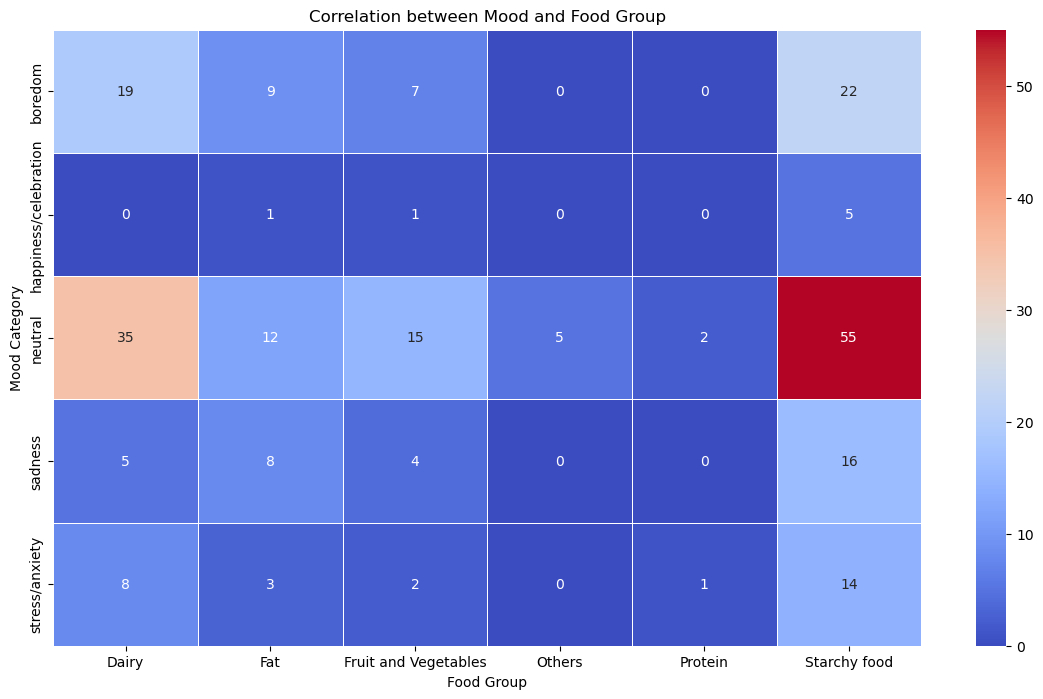

In [36]:
plt.figure(figsize=(14, 8))
food_mood_corr = df_exploded.groupby(['mood_category', 'food_group']).size().unstack().fillna(0)
sns.heatmap(food_mood_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Mood and Food Group')
plt.ylabel('Mood Category')
plt.xlabel('Food Group')
plt.show()

# 2. Horizontal Bar Grap - shows the distribution of Food Group

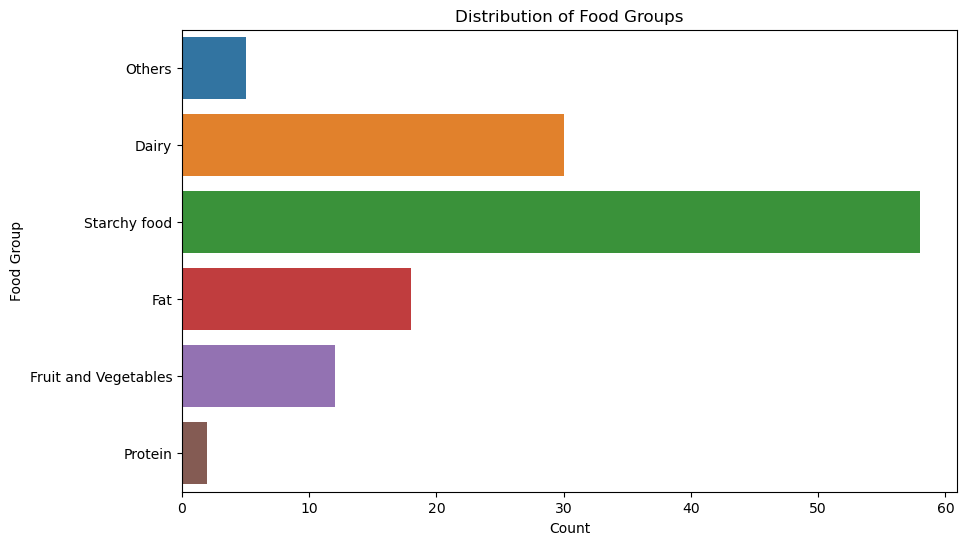

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(y='food_group', data=df)
plt.title('Distribution of Food Groups')
plt.xlabel('Count')
plt.ylabel('Food Group')
plt.show()

# 3. Pie Chart - shows the distribution of Gender (male/female)

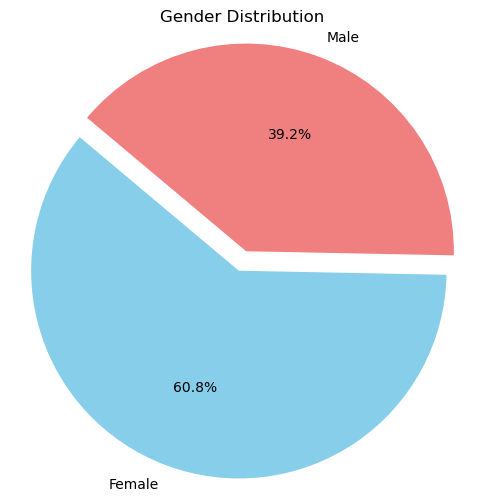

In [38]:
gender_mapping = {1: 'Female', 2: 'Male'}
df['Gender'] = df['Gender'].map(gender_mapping)

plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], explode=(0.1, 0), startangle=140)
plt.title('Gender Distribution')
plt.ylabel('')
plt.axis('equal')
plt.show()

# 4. Word Cloud - shows the frequency of comfort food reasons

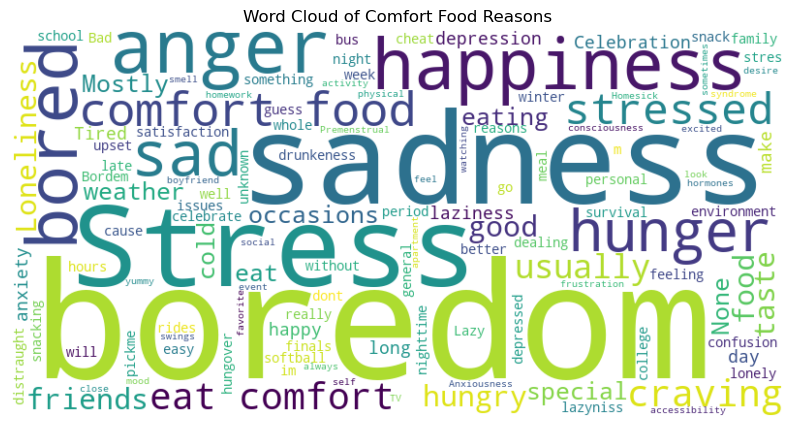

In [39]:
comfort_food_reasons_text = df['comfort_food_reasons'].astype(str).values
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(comfort_food_reasons_text))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Comfort Food Reasons')
plt.axis('off')
plt.show()

# 5. Vertical Bar Grap - shows the distribution of Employment Status


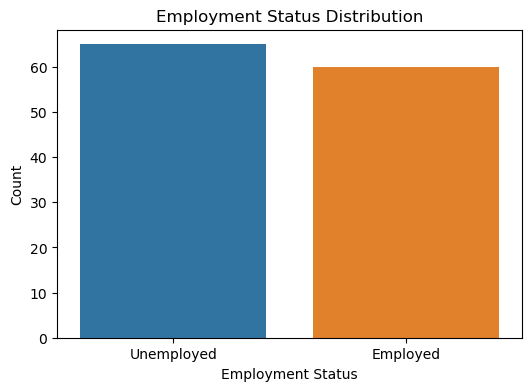

In [40]:
plt.figure(figsize=(6, 4))
sns.countplot(x='employment', data=df.replace({'employment': {1: 'Employed', 2: 'Unemployed'}}))
plt.title('Employment Status Distribution')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()